In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from scipy import stats

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


In [2]:
df = pd.read_csv("bitcoin.csv")
df.head()

,date,price,total_volume,market_cap,coin_name
0,2015-01-01 00:00:00.000,313.992,4.699936e+07,4.293958e+09,bitcoin
1,2015-01-02 00:00:00.000,314.446,3.885591e+07,4.301448e+09,bitcoin
2,2015-01-03 00:00:00.000,286.572,1.187789e+08,3.921358e+09,bitcoin
3,2015-01-04 00:00:00.000,260.936,2.055001e+08,3.571640e+09,bitcoin
4,2015-01-05 00:00:00.000,273.220,1.550381e+08,3.740880e+09,bitcoin


We have price, volume and marketcap information in the dataset apart from the date.

* price represents the price of bitcoin in USD on the given date
* total_volume represents the total volume traded in USD on the given date
* market_cap represents the market capitalization of bitcoin on the given date

<AxesSubplot: >

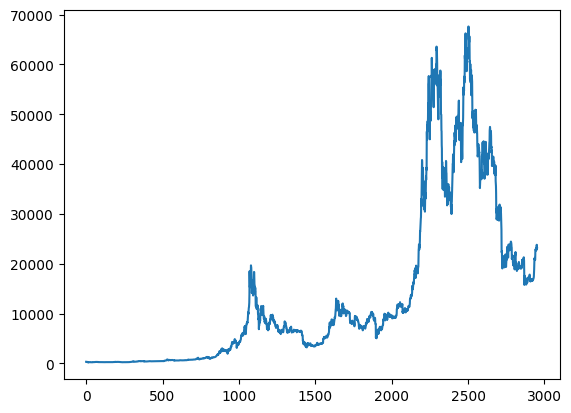

In [3]:
df["price"].plot()

The price of the bitcoin ranges from ~250 USD to ~70,000 USD in the dataset. This is a huge range.

We need a target variable which is not as volatile as this and also makes business sense.

So, I need to modify the target variable as **predict the percentage of price change (Price on t+1 day / Price on t day)** which will be range bound and also can be used to make business decisions.

In [6]:
def create_features(df):
    features_to_use = []
    # We will create features based on last 5 days
    for day_value in range(5):
        # Price based features
        df[f"price_{day_value}day_previous"] = df["price"].shift(day_value)
        # Percent change of price
        df[f"price_change_{day_value}day"] = df["price"] / df[f"price_{day_value}day_previous"]
        features_to_use.append(f"price_change_{day_value}day")
        # Volume based features
        df[f"volume_{day_value}day_previous"] = df["total_volume"].shift(day_value)
        df[f"volume_change_{day_value}day"] = df["total_volume"] / df[f"volume_{day_value}day_previous"]
        features_to_use.append(f"volume_change_{day_value}day")     
    return df, features_to_use

def create_target(df):
    df["price_next_day"] = df["price"].shift(-1)
    df["target"] = df["price_next_day"] / df["price"]
    # We will remove the rows where the target is null
    df = df[~df["target"].isnull()].reset_index(drop=True)
    return df

def get_validation_test_split(df, features_to_use, val_days=30, test_days=30):
    X = df[features_to_use]
    y = df["target"].values
    test_index = - test_days
    val_index = test_index - val_days
    dev_X, val_X, test_X = X.iloc[:val_index,:], X.iloc[val_index:test_index,:], X.iloc[test_index:,:]
    dev_y, val_y, test_y = y[:val_index], y[val_index:test_index], y[test_index:]
    return dev_X, dev_y, val_X, val_y, test_X, test_y

In [7]:
# feature creation
df, features_to_use = create_features(df)

# target_creation
df = create_target(df)

# data split
train_X, train_y, val_X, val_y, test_X, test_y = get_validation_test_split(df, features_to_use)
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)

(2892, 10) (2892,) (30, 10) (30,) (30, 10) (30,)


<AxesSubplot: >

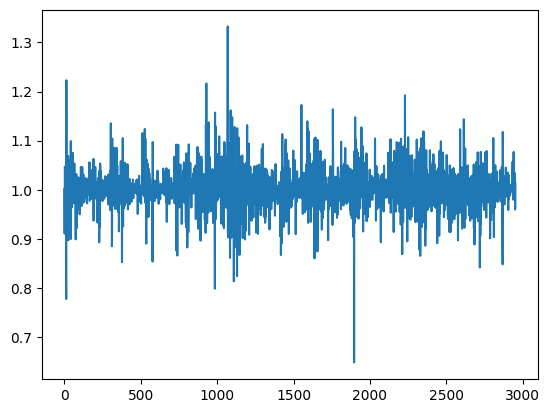

In [8]:
df["target"].plot()

The **target (percentage of price change)**  range are not as wide as the absolute price values.

## Handling Missing values

In [9]:
train_X = train_X.fillna(method="bfill")
val_X = val_X.fillna(method="bfill")
test_X = test_X.fillna(method="bfill")

## Model Building

In [10]:
model = LinearRegression()
model.fit(train_X, train_y)

LinearRegression()

In [11]:
pred_val_y = model.predict(val_X)
stats.spearmanr(val_y, pred_val_y).correlation


0.12302558398220245

spearman correlation is positive for our validation dataset

This means our model is weakly learning the features

### Performance Evaluation

In [14]:
pred_train_y = model.predict(train_X)
model_cutoff = np.median(pred_train_y)
model_cutoff

1.0021996570014446

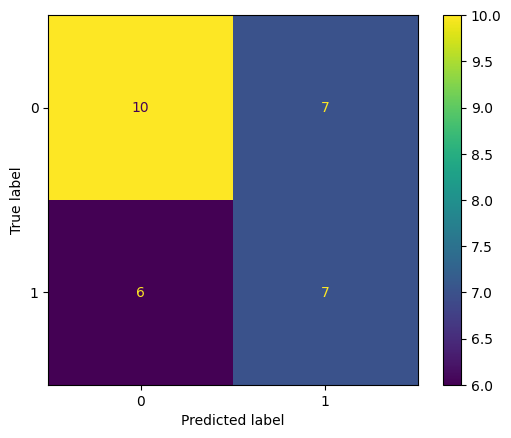

In [15]:
binary_target_value_val = val_y>1
binary_prediction_value_val = pred_val_y>model_cutoff
cm = confusion_matrix(binary_target_value_val, binary_prediction_value_val)
cm_display = ConfusionMatrixDisplay(cm).plot()

It signifies that our of 30 days model is predicting correct for 17 cases 